In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from pandas.core.common import flatten

import torch
import os
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import  DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import random
import glob as glob
from skimage import io 

import sys
sys.path.insert(0, "/Users/alex_christlieb/Documents/Ecole Polytechnique/Exchange/DTU/Courses/Deep Learning/autotetris")

from lib.dataloader import RoofDataSet, Transforms, show_centroids
from lib.modeltraining import VarDiffloss, Resnet18_GAP, Resnet18,  train_model, test_model


#### Load Data

Using the defined classes and functions in `dataloader.py`, it is easy to load the dataset. 

In [3]:
# The path to the metadata.hdf file must be stored in a string
path = "/Users/alex_christlieb/Desktop/small_sample_out/metadata_sample.hdf"

In [3]:
raw_data = RoofDataSet(path, transform=None)

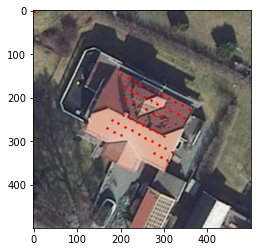

In [5]:
# Querying an index in the data loader
img, centroid = raw_data[7]

show_centroids(img, centroids=centroid, tensor=False)

#### Transform Data

The following code loads the data into a dataset. The `transform` argument in the `Transforms()` allows for a series of transformations to be called, where the input must be a list of transform functions. By default, it is configured to `['resize', 'to_tensor']`.

In [6]:
transformed_data = RoofDataSet(path, transform=Transforms(new_size=(256,256)))

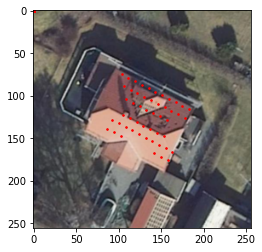

In [7]:
# Querying an index in the data loader
img, centroid = transformed_data[7]

show_centroids(img, centroids=centroid, tensor=True)

#### Split the dataset into test and validate

In [8]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(transformed_data))
len_train_set = len(transformed_data) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset, = torch.utils.data.random_split(transformed_data , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=4)

The length of Train set is 90
The length of Valid set is 10


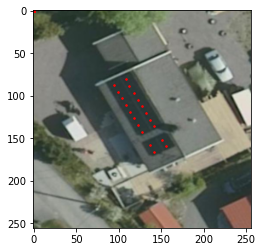

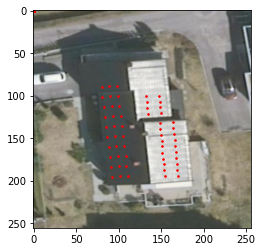

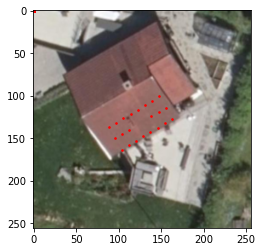

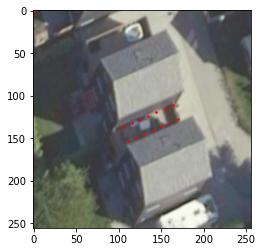

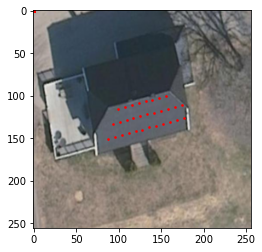

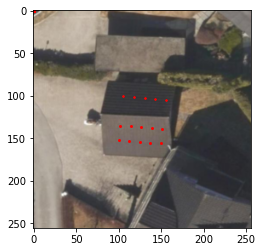

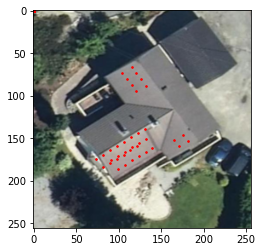

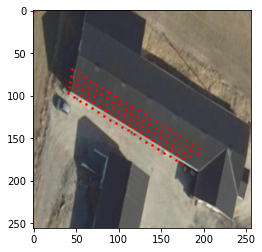

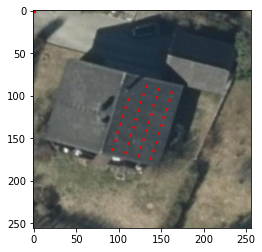

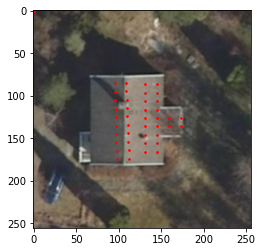

In [12]:
# plotting the validation dataset 
for house in valid_dataset:
    img, centroids = house
    show_centroids(img, centroids, tensor = True)

#### Plotting data from batches

In [13]:
# printing size of data 
images, centroids = next(iter(train_loader))

print(images.shape)
print(centroids.shape)

torch.Size([64, 3, 256, 256])
torch.Size([64, 106, 2])


### Full Dataset


In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from pandas.core.common import flatten

import torch
import os
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import  DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import random
import glob as glob
from skimage import io 

import sys
sys.path.insert(0, "/Users/alex_christlieb/Documents/Ecole Polytechnique/Exchange/DTU/Courses/Deep Learning/autotetris")

from lib.dataloader import RoofDataSet, Transforms, show_centroids
from lib.modeltraining import VarDiffloss, Resnet18_GAP, Resnet18,  train_model, test_model, plot_activation_map_coordinates, plot_activation_map_images


In [2]:
path = "/Users/alex_christlieb/Desktop/small_sample_out/metadata_sample.hdf"
full_path = "/Users/alex_christlieb/Downloads/Dataset/data_2022-11-01/meta_data.hdf"
raw_data = RoofDataSet(full_path, transform=Transforms(), mode = "constant")

-------------------- Initializing dataset --------------------
--> Metadata read
--> Num_panels computed
--> Samples with many panels dropped
--> Padding samples
--> Dataset ready


In [3]:
# split the dataset into training, validation and test sets
# Create testset
len_test_set = int(0.1*len(raw_data))
len_train_set = len(raw_data) - len_test_set

train_dataset , test_dataset  = torch.utils.data.random_split(raw_data, [len_train_set, len_test_set],  generator=torch.Generator().manual_seed(1))

len_valid_set = int(0.2*len(train_dataset))
len_train_set = len(train_dataset) - len_valid_set

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [len_train_set, len_valid_set],  generator=torch.Generator().manual_seed(1))

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))
print("The length of Test set is {}".format(len_test_set))


# shuffle and batch the datasets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
test_trained = DataLoader(train_dataset, batch_size=1, shuffle=True)

The length of Train set is 12715
The length of Valid set is 3178
The length of Test set is 1765


In [4]:
Path = "/Users/alex_christlieb/Documents/Ecole Polytechnique/Exchange/DTU/Courses/Deep Learning/autotetris/trained_models/resnet_gap_03_12_22_j-v1.pt"
model = torch.load(Path, map_location=torch.device('cpu'))
model.eval()


Resnet18_GAP(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

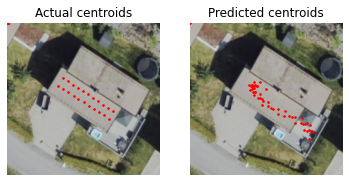

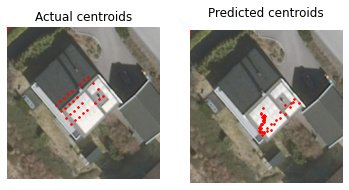

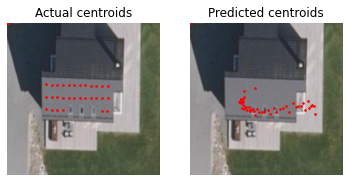

[tensor([[[ 1.7086e+02,  1.7541e+02],
          [ 1.6088e+02,  1.8025e+02],
          [ 1.5854e+02,  1.7781e+02],
          [ 1.5815e+02,  1.7560e+02],
          [ 1.5878e+02,  1.7201e+02],
          [ 1.4949e+02,  1.7699e+02],
          [ 1.5761e+02,  1.6804e+02],
          [ 1.4744e+02,  1.7231e+02],
          [ 1.4904e+02,  1.6915e+02],
          [ 1.4820e+02,  1.6557e+02],
          [ 1.4683e+02,  1.6278e+02],
          [ 1.3968e+02,  1.6450e+02],
          [ 1.4701e+02,  1.5376e+02],
          [ 1.3858e+02,  1.5483e+02],
          [ 1.3776e+02,  1.5019e+02],
          [ 1.3652e+02,  1.4488e+02],
          [ 1.3685e+02,  1.3866e+02],
          [ 1.2918e+02,  1.3961e+02],
          [ 1.3443e+02,  1.2926e+02],
          [ 1.2703e+02,  1.2965e+02],
          [ 1.2668e+02,  1.2187e+02],
          [ 1.2465e+02,  1.1874e+02],
          [ 1.2234e+02,  1.1474e+02],
          [ 1.1636e+02,  1.1508e+02],
          [ 1.2117e+02,  1.0631e+02],
          [ 1.1514e+02,  1.0788e+02],
          [ 

In [15]:
test_model(model, test_loader, 3)

In [7]:
train_loss = np.loadtxt("./trained_models/train_loss_30_02_11.csv", delimiter="\n")
val_loss = np.loadtxt("./trained_models/val_loss_20_02_11.csv", delimiter="\n")

In [8]:
steps = np.arange(len(train_loss))

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Loss'))

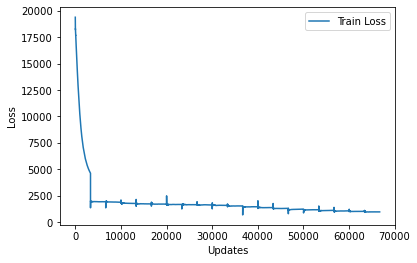

In [9]:
plt.figure()
plt.plot(steps, train_loss)
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Updates'), plt.ylabel('Loss')

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

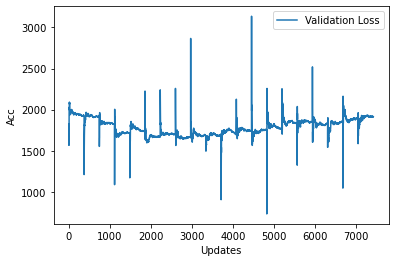

In [10]:
plt.figure()
plt.plot(np.arange(len(val_loss)), val_loss)
plt.legend(['Validation Loss'])
plt.xlabel('Updates'), plt.ylabel('Acc')

In [16]:
it_train = iter(test_loader)
image, centroid = next(it_train)

prediction = model(image)

prediction = prediction.view(-1, 50, 2)
prediction = prediction.detach()
prediction = prediction[0]

image = image.squeeze()
# image = image.permute(1, 2, 0)

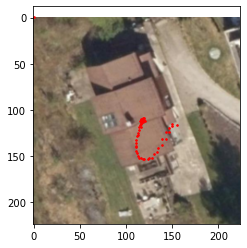

In [17]:
show_centroids(image, prediction, tensor=True)

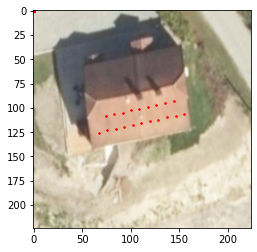

In [11]:
show_centroids(image, centroid[0], tensor=True)

## Testing to display the class activation map GAP

In [4]:
network = Resnet18_GAP(num_classes=raw_data.max_num_panels*2)
# network = Resnet18(num_classes=raw_data.max_num_panels*2)
criterion = VarDiffloss()
# SGD diverges on our model
# optimizer = optim.SGD(network.parameters(), lr=0.0001)
optimizer = optim.Adam(network.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

loss_min = 0.001
num_epochs = 5

# Train model
# model = train_model(network, criterion, optimizer, num_epochs, train_loader, valid_loader)


In [12]:
it_train = iter(test_loader)
image, centroid = next(it_train)

conv_output, predict = network(image)
conv_output.shape
# prediction 

torch.Size([1, 512, 7, 7])

In [ ]:
from torchsummary import summary
summary(network, input_size=(3, 224,224))

#### Heatmap

In [15]:
from scipy.ndimage import zoom
conv_output = np.squeeze(conv_output)
mat_for_mult = zoom(conv_output.detach(), (32, 32, 1), order=1) # dim: 224 x 224 x 2048


In [31]:
weights = network.fc.weight
# cam = torch.mm(prediction, weights)
coordinates = weights[0,:].detach()
weights.shape

torch.Size([74, 512])

In [24]:
mat_for_mult.reshape((224*224, 512)).shape

(50176, 512)

In [28]:
coordinates.shape

torch.Size([512])

In [32]:
final_output = np.dot(mat_for_mult.reshape((224*224, 512)), coordinates).reshape(224,224) # dim: 224 x 224

In [34]:
final_output.shape

(224, 224)

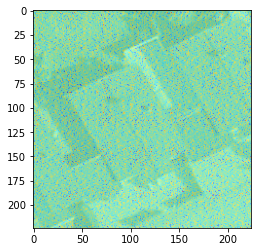

In [44]:
image = image.squeeze()
image = image.permute(0, 2, 1)



plt.imshow(image, alpha=0.5)
plt.imshow(final_output, cmap='jet', alpha=0.5)

In [41]:
image.shape

torch.Size([224, 3, 224])

In [50]:
t = torch.rand(2,3,1,1)

In [51]:
t.squeeze().shape

torch.Size([2, 3])

Parameter containing:
tensor([[ 0.1198,  0.0990,  0.1441,  ...,  0.1647,  0.1741,  0.0860],
        [ 0.0838,  0.0912,  0.1205,  ...,  0.1579,  0.0949,  0.1308],
        [ 0.1254,  0.1243,  0.0731,  ...,  0.1020,  0.1903,  0.0669],
        ...,
        [ 0.1144,  0.0844,  0.1025,  ...,  0.0574,  0.1322,  0.0795],
        [-0.0003,  0.0276,  0.0095,  ..., -0.0144, -0.0238, -0.0115],
        [ 0.0145,  0.0233, -0.0314,  ...,  0.0132,  0.0281, -0.0065]],
       requires_grad=True)


No handles with labels found to put in legend.
No handles with labels found to put in legend.


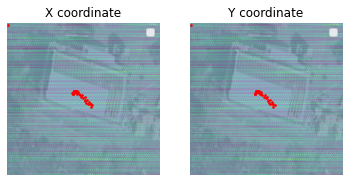

Parameter containing:
tensor([[ 0.1198,  0.0990,  0.1441,  ...,  0.1647,  0.1741,  0.0860],
        [ 0.0838,  0.0912,  0.1205,  ...,  0.1579,  0.0949,  0.1308],
        [ 0.1254,  0.1243,  0.0731,  ...,  0.1020,  0.1903,  0.0669],
        ...,
        [ 0.1144,  0.0844,  0.1025,  ...,  0.0574,  0.1322,  0.0795],
        [-0.0003,  0.0276,  0.0095,  ..., -0.0144, -0.0238, -0.0115],
        [ 0.0145,  0.0233, -0.0314,  ...,  0.0132,  0.0281, -0.0065]],
       requires_grad=True)


No handles with labels found to put in legend.
No handles with labels found to put in legend.


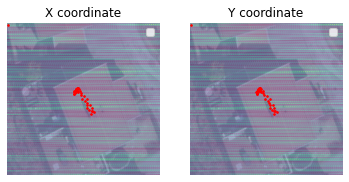

Parameter containing:
tensor([[ 0.1198,  0.0990,  0.1441,  ...,  0.1647,  0.1741,  0.0860],
        [ 0.0838,  0.0912,  0.1205,  ...,  0.1579,  0.0949,  0.1308],
        [ 0.1254,  0.1243,  0.0731,  ...,  0.1020,  0.1903,  0.0669],
        ...,
        [ 0.1144,  0.0844,  0.1025,  ...,  0.0574,  0.1322,  0.0795],
        [-0.0003,  0.0276,  0.0095,  ..., -0.0144, -0.0238, -0.0115],
        [ 0.0145,  0.0233, -0.0314,  ...,  0.0132,  0.0281, -0.0065]],
       requires_grad=True)


No handles with labels found to put in legend.
No handles with labels found to put in legend.


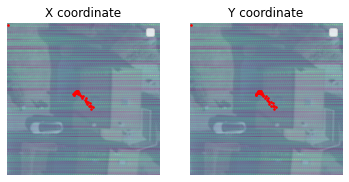

In [5]:
plot_activation_map_images(model, test_loader, 3, 0,20)